# Functions minimization with this CBO implementation

This notebook gives a brief introduction to how to use the CBO implementation provided in the repo.

First of all, it is required to add the path to the `src` folder of this repo to `sys.path`. For example, in the case of this notebook, it can be specified as follows:

In [1]:
import os
import sys
sys.path.append(os.path.join(os.pardir, 'src'))

An alternative approach is to update the `PYTHONPATH` environment variable.

## Minimize

For exploratory purposes, it might be helpful to apply CBO for optimizing functions, which aren't losses. This implementation provides an ad hoc interface through the `minimize` function:

In [2]:
from CBO.minimize import minimize

This function takes multiple arguments:
* `objective`: functions to minimizer, see more below;
* `dimensionality`: dimensionality of the `objective` function domain;
* `n_particles`: number of particles to use in the dynamics;
* `time_horizon`: optimization time horizon;
* `optimizer_config`: config to pass to the optimizer, see more below;
* `initial_distribution`: initial distribution to sample the particles from, see more below;
* `return_trajectory`: bool flag, when set, the function call will also return the optimization trajectory (to use in the visualizations);
* `return_trajectory`: show progress bar.
It returns the resulting point and optionally the trajectory (if `return_trajectory` set).

### `objective`

The passed objective function should be compatible with the TensorFlow operations. Thus, if it uses the mathematical operations, they should be supported on the TensorFlow tensors. Some functions are already implemented in the `CBO.functions`:

In [3]:
from CBO.functions import rastrigin, rastrigin_c, square

For example, the rastrigin function with a constant `c` can be implemented in the following way:
```
import tensorflow as tf

def rastrigin_c(c):
    tf.reduce_sum(v ** 2 - c * tf.math.cos(2 * np.pi * v)) + c * tf.cast(tf.size(v), tf.float32)
```

However, if the objective function can be expressed via the native Python, it is possible to pass it as lambda instead. For example
```
lambda v: v**2 + v**3 / 2
```
is a valid objective function.

### `optimizer_config`

This configuration can be specified as a dictionary with the optimization hyperparameters. More specifically, the dict may only have keys from the following list:
* `dt`: optimization step;
* `lmbda`: lambda hyperparameter from CBO;
* `sigma`: sigma hyperparameter from CBO;
* `alpha`: alpha hyperparameter from CBO;
* `anisotropic`: bool flag, which indicates if the noise should be isotropic or anisotropic.

A `DEFAULT_OPTIMIZER_CONFIG` below is a valid example of the config.

When a specific argument is omitted in the configuration, its' default values is used. Default argument values:
```
DEFAULT_OPTIMIZER_CONFIG = {
    'dt': 0.02,
    'lmbda': 1,
    'sigma': 1,
    'alpha': 100,
    'anisotropic': True,
}
```

### `initial_distribution`

Initial distribution should be a distribution from the `TensorFlow Probability` library. For convinience, some distributions are provided in the `CBO.distributions`:

In [4]:
from CBO.distributions import Normal

A distribution imported above is a ready-to-use distribution, which takes `loc` and `scale` as arguments.

Let's consider the following example:

In [5]:
minimizer, trajectory = minimize(rastrigin_c(2.5), dimensionality=1, n_particles=100, time_horizon=2, 
                                  return_trajectory=True, optimizer_config = {
                                      'alpha': 1000,
                                      'sigma': 0.2,
                                  },
                                  initial_distribution=Normal(2, 3))

100%|██████████| 101/101 [00:16<00:00,  6.18it/s]


The function call above returned the `minimizer` and `trajectory`. `minimizer` is a TensorFlow tensor:

In [6]:
minimizer

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.04112562]], dtype=float32)>

`trajectory` is a dict, which for each timestamp of optimization tracks the location of all the particles as well as the consensus point. It can be used for the visualization purposes. `CBO.visualizations` provides some ready-to-use visualization functions. For example:

### Visualizations

In [7]:
from CBO.visualizations import visualize_trajectory_convergence

This function will plot the convergence of CBO. More specifically, it plots the $\frac{V^N(\rho_t^N)}{V^N(\rho_0^N)}$ over the optimization duration, and compares it with the theoretical convergence. It allows specifying the `output_path` argument to save the plot.

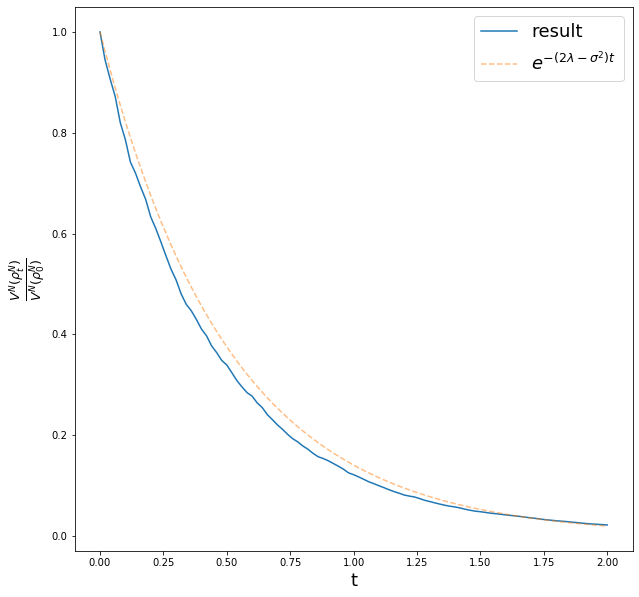

In [8]:
visualize_trajectory_convergence(trajectory, 0, display_exponent=True, exp_sigma=0.2)

Additionally, it is possible to visualize the trajectory as a gif. However, it is only supported for 1d functions at the moment.

In [9]:
from CBO.visualizations import visualize_trajectory_1d

100%|██████████| 101/101 [00:33<00:00,  3.00it/s]


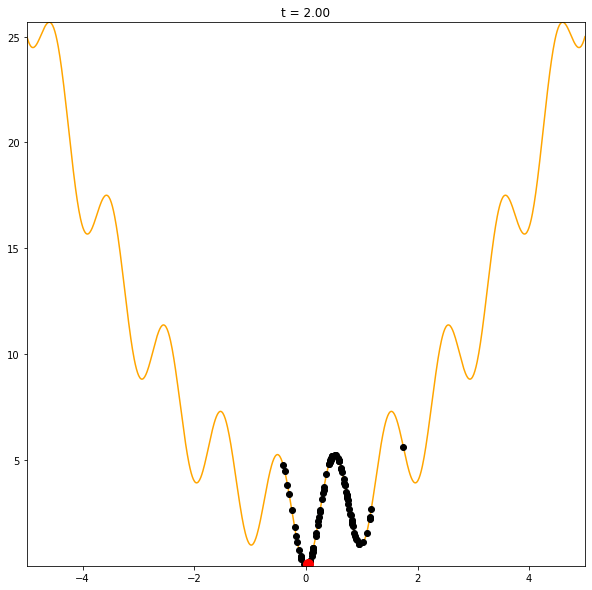

In [10]:
visualize_trajectory_1d(trajectory, rastrigin_c(2.5), x_range=(-5, 5), output_path='example.gif')

It is possible to load the gif into the jupyter notebook in the following way:

In [11]:
from IPython.display import Image
Image(url='example.gif')

Optimization success depends on the set of its arguments. One can use the `minimize_for_ranges` function for these purposes:

In [12]:
from CBO.minimize import minimize_for_ranges

This function has an interface similar to the minimize function interface. Additionally, it can take the following arguments: `alphas`, `ns_particles`, `sigmas`, `dts`. These arguments are optional. minimize_for_ranges will generate a list of all the possible combinations of argument values (~ Cartesian product) and conduct an optimization for each of them. Another additional argument, `n_repeats`, specifies how many times to repeat the optimization for each configuration. The function will return all the `n_repeats` found minimizer for each configuration.

Set the `verbose` argument to `True` to display the progress bars.

In [13]:
results = minimize_for_ranges(rastrigin_c(2.5), dimensionality=1, time_horizon=2, 
                              default_optimizer_config = {
                                  'sigma': 0.2,
                              },
                              initial_distribution=Normal(2, 3),
                              alphas=[10, 100, 1000, 10000],
                              ns_particles=range(10, 101, 10),
                              n_repeats=10, verbose=False)

To visualize the obtained results, one can use the `visualize_minimization_successfulness` function from the `CBO.visualizations`:

In [14]:
from CBO.visualizations import visualize_minimization_successfulness

This function takes the produced above results as well two names of arguments (`alpha` / `n_particles` / `sigma`, `dt`) to use as x-axis and y-axis variables. The most important argument of this function is success_criterion: a function that identifies by the found minimizer if the optimization was successful or not.

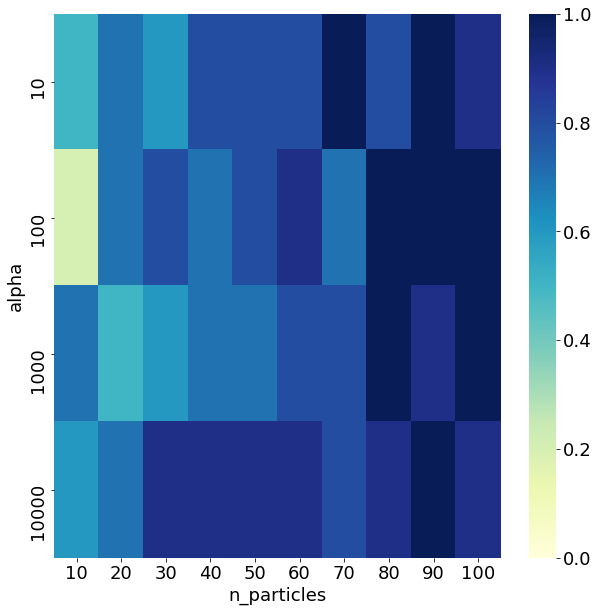

In [16]:
visualize_minimization_successfulness('alpha', 'n_particles', results, 
                                      success_criterion=lambda v: abs(v) < 0.2)